In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from xgboost import XGBClassifier

In [2]:
#I Data analysis

In [3]:
#1 Loading Dataset
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
#2 Identifying Duplicates
print(f"Duplicates in Train Dataset is:{train_df.duplicated().sum()}")
print(f"Duplicates in Test Dataset is:{test_df.duplicated().sum()}")

Duplicates in Train Dataset is:0
Duplicates in Test Dataset is:0


In [5]:
#3 Checking data types 
print("Data Types of features of Training Data is:")
print(train_df.dtypes)
print("\nData types of features of Testing Data is:")
print(test_df.dtypes)

Data Types of features of Training Data is:
PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

Data types of features of Testing Data is:
PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
dtype: object


In [6]:
#4 Looking for missing values
df1 = (train_df.isnull().sum()[train_df.isnull().sum()>0]).to_frame().rename(columns={0:"Number of Missing values"})
df1["% of Missing Values"] = round((100*train_df.isnull().sum()[train_df.isnull().sum()>0]/len(train_df)),2)
df1

,Number of Missing values,% of Missing Values
HomePlanet,201,2.31
CryoSleep,217,2.50
Cabin,199,2.29
Destination,182,2.09
Age,179,2.06
VIP,203,2.34
RoomService,181,2.08
FoodCourt,183,2.11
ShoppingMall,208,2.39
Spa,183,2.11


In [7]:
df2 = (test_df.isnull().sum()[test_df.isnull().sum()>0]).to_frame().rename(columns={0:"Number of Missing values"})
df2["% of Missing Values"] = round((100*test_df.isnull().sum()[test_df.isnull().sum()>0]/len(test_df)),2).values
df2

,Number of Missing values,% of Missing Values
HomePlanet,87,2.03
CryoSleep,93,2.17
Cabin,100,2.34
Destination,92,2.15
Age,91,2.13
VIP,93,2.17
RoomService,82,1.92
FoodCourt,106,2.48
ShoppingMall,98,2.29
Spa,101,2.36


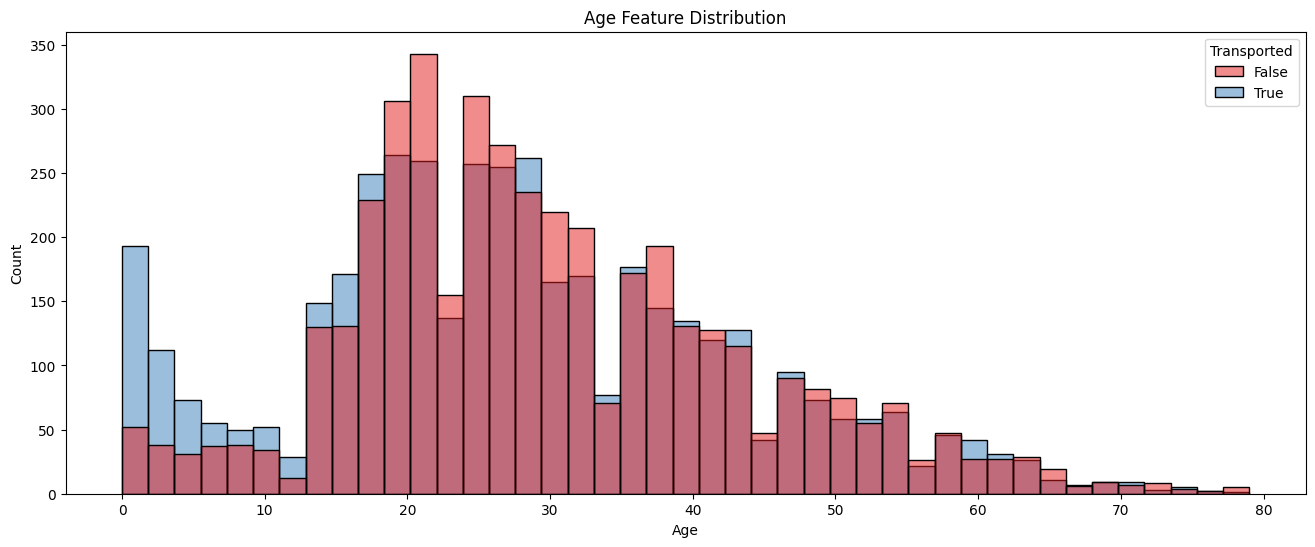

In [8]:
#5 Visualizing: age
plt.figure(figsize=(16,6))
sns.histplot(x=train_df["Age"],hue="Transported",data=train_df,palette="Set1")
plt.title("Age Feature Distribution");

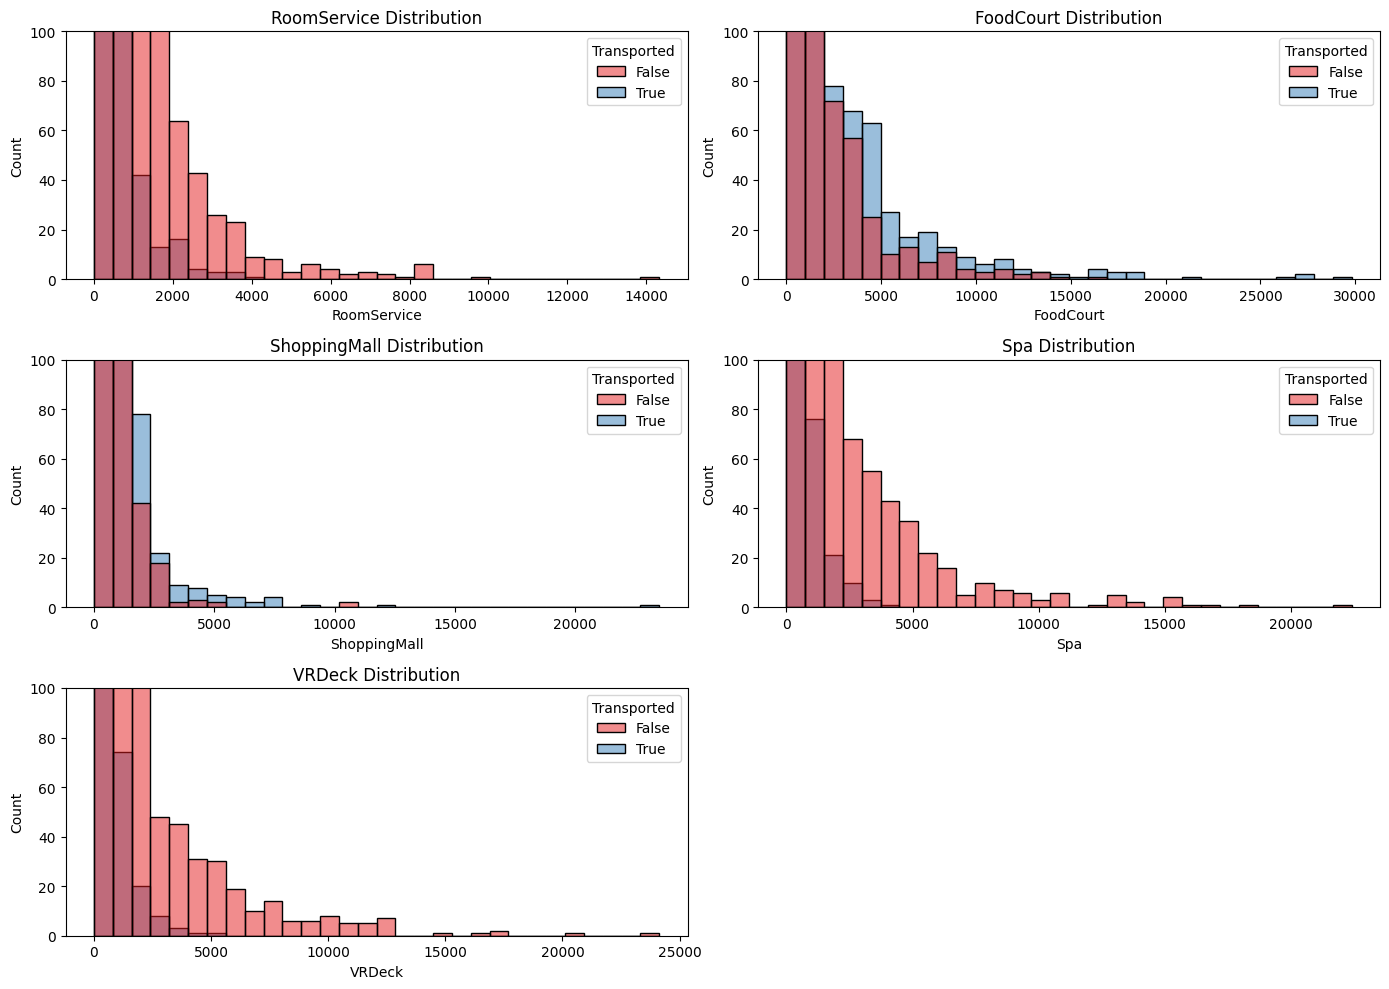

In [9]:
#6 Visualizing: RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
exp_cols = ["RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]

plt.figure(figsize=(14,10))
for idx,column in enumerate(exp_cols):
    plt.subplot(3,2,idx+1)
    sns.histplot(x=column, hue="Transported", data=train_df,bins=30,palette="Set1")
    plt.title(f"{column} Distribution")
    plt.ylim(0,100)
    plt.tight_layout()

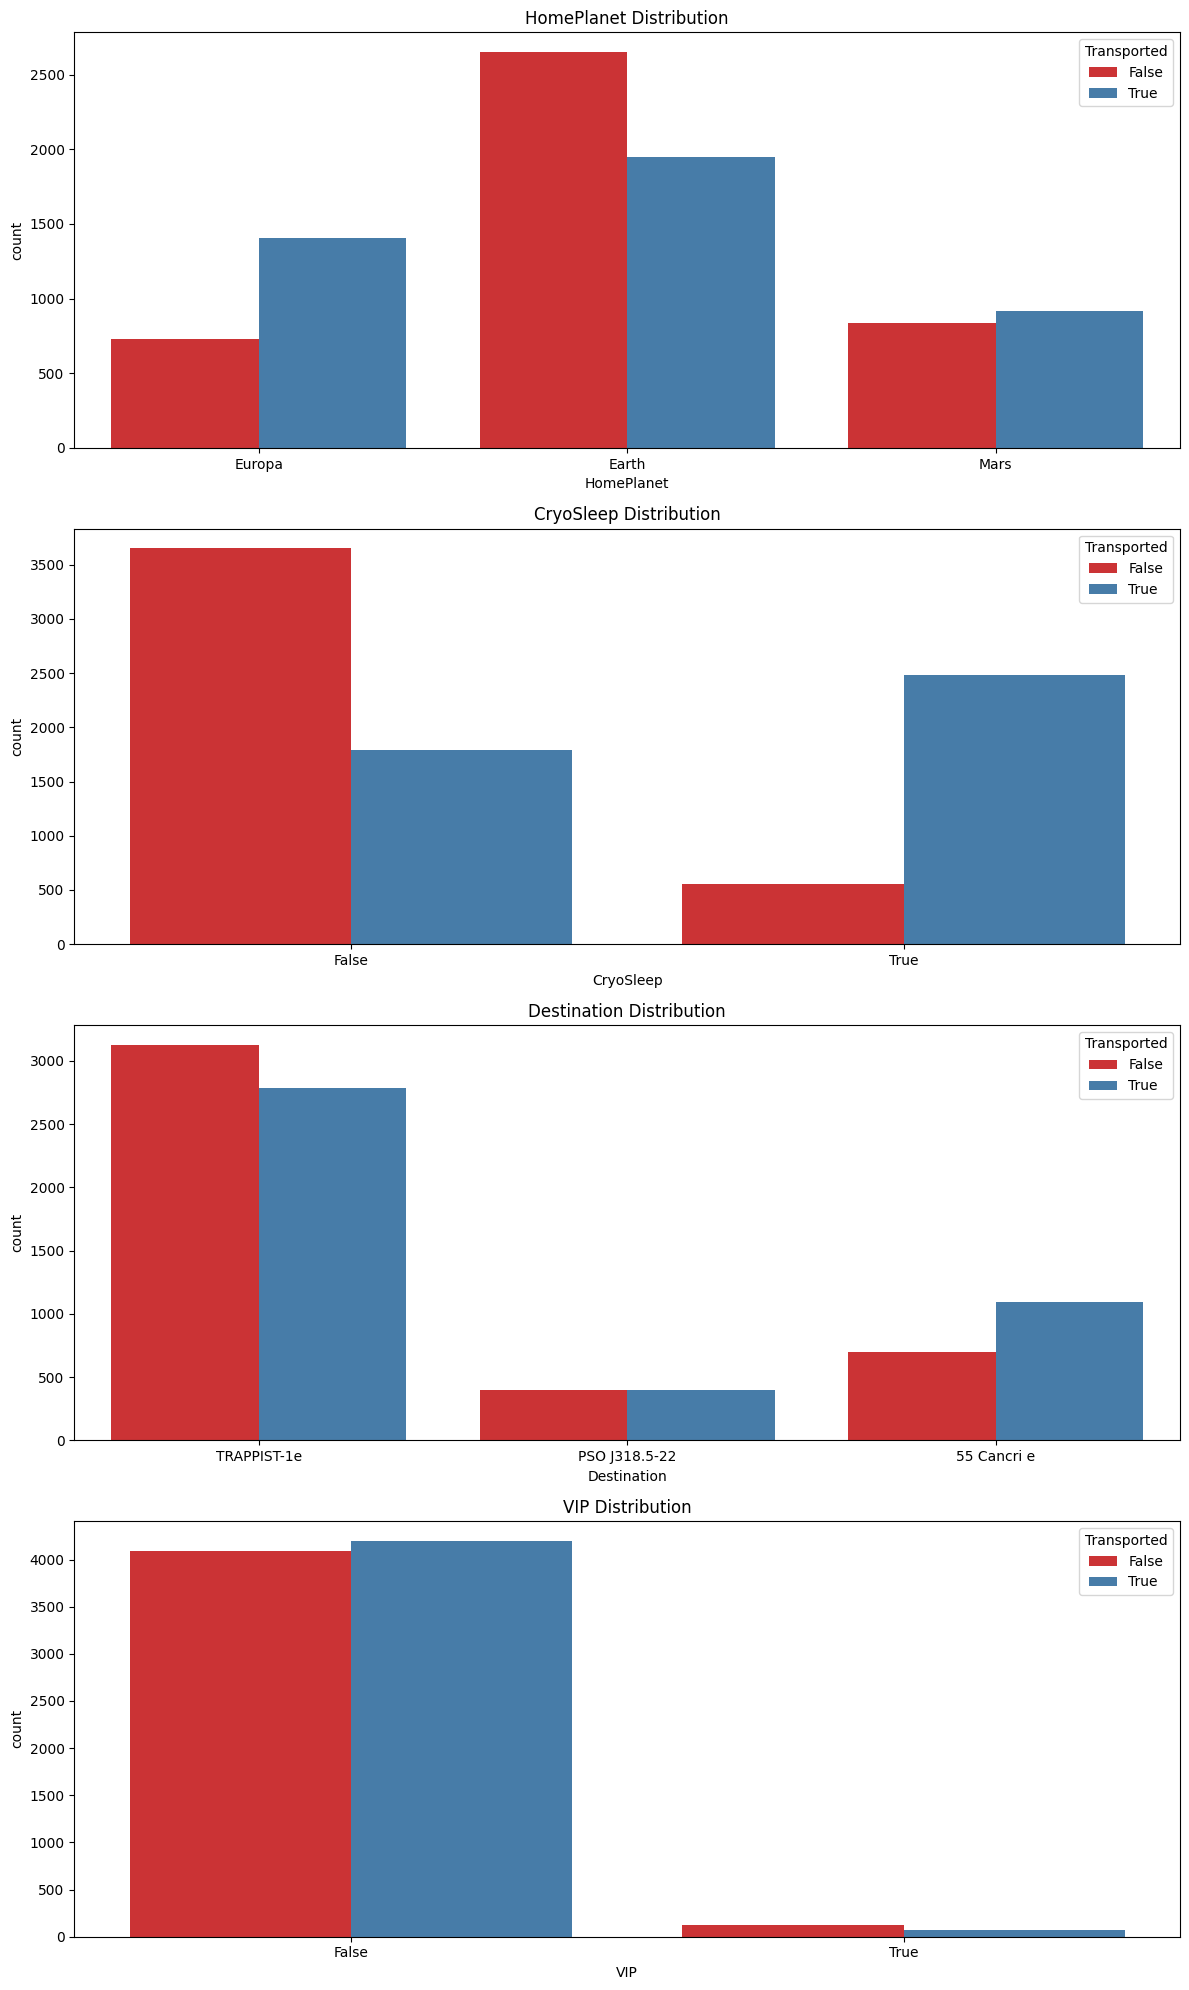

In [10]:
#7 Visualizing(categrical): RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
cat_cols = ["HomePlanet","CryoSleep","Destination","VIP"]

plt.figure(figsize=(12,20))
for idx,column in enumerate(cat_cols):
    plt.subplot(4,1,idx+1)
    sns.countplot(x=column, hue="Transported", data=train_df, palette="Set1")
    plt.title(f"{column} Distribution")
    plt.tight_layout()

In [11]:
#II Feature Extraction

In [12]:
#1 PassengerId--> Group_Size, Travelling_Solo
def passengerid_new_features(df):
    
    #Splitting "PassengerId" column.
    df["Group"] = df["PassengerId"].apply(lambda x: x.split("_")[0])
    df["Member"] =df["PassengerId"].apply(lambda x: x.split("_")[1])
    
    #Grouping the "Group" feature wrt "member" feature to check which group is travelling with how many members
    x = df.groupby("Group")["Member"].count().sort_values()
    
    #set of group values with more than 1 members.
    y = set(x[x>1].index)
    
    # New feature "Solo" , indicates whether the person is travelling solo or not.
    df["Travelling_Solo"] = df["Group"].apply(lambda x: x not in y)
    
    # New feature "Group_size" which will indicate each group's number of members.
    df["Group_Size"]=0
    for i in x.items():
        df.loc[df["Group"]==i[0],"Group_Size"]=i[1]

In [13]:
passengerid_new_features(train_df)
passengerid_new_features(test_df)

In [14]:
# Dropping Group & Member feature
train_df.drop(columns=["Group","Member"],inplace=True)
test_df.drop(columns=["Group","Member"],inplace=True)

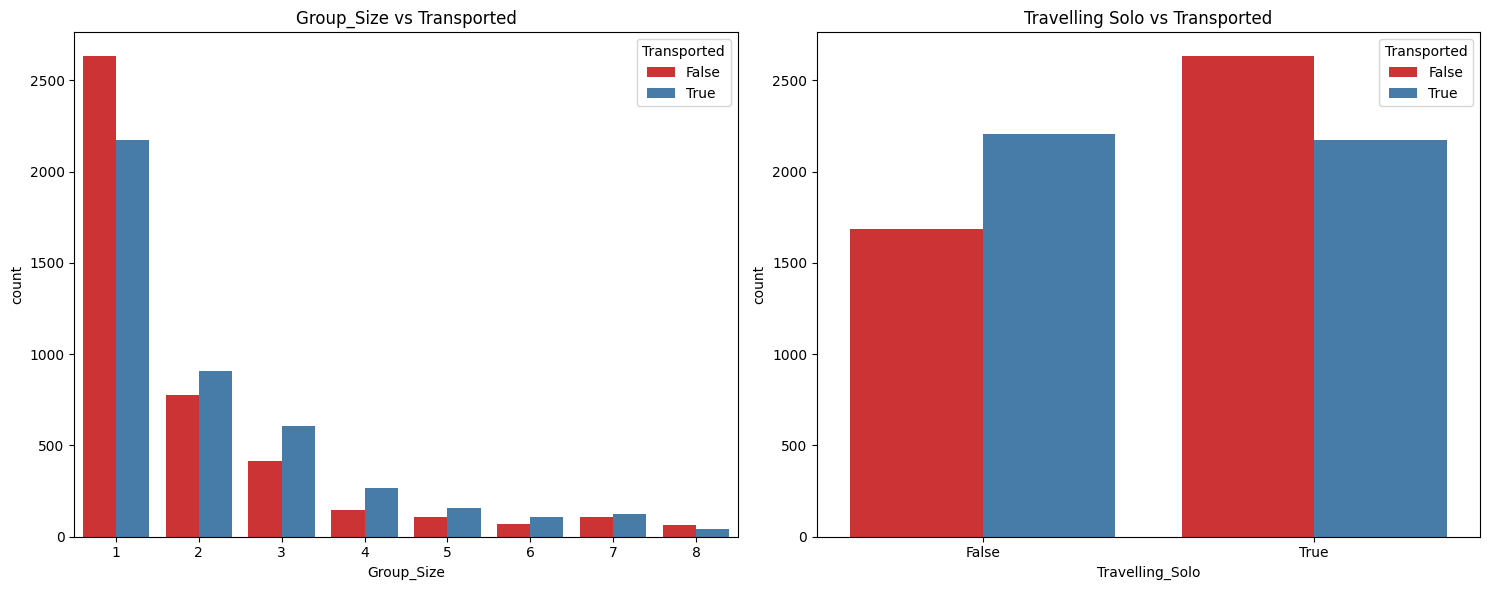

In [15]:
#Visualizing: Group_Size, Travelling_Solo 
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
sns.countplot(x="Group_Size", hue="Transported", data=train_df,palette="Set1")
plt.title("Group_Size vs Transported")

plt.subplot(1,2,2)
sns.countplot(x="Travelling_Solo", hue="Transported", data=train_df,palette="Set1")
plt.title("Travelling Solo vs Transported")
plt.tight_layout()
plt.show()

In [16]:
#2 Cabin-->Cabin_Deck, Cabin_Number, Cabin_Side 
def cabin_new_feature(df):
    # Ensure all values in Cabin are strings
    df["Cabin"] = df["Cabin"].fillna("np.nan/np.nan/np.nan").astype(str)
    
    #Handling NaN values while splitting
    df["Cabin"].fillna("np.nan/np.nan/np.nan")  
    
    df["Cabin_Deck"] = df["Cabin"].apply(lambda x: x.split("/")[0])
    df["Cabin_Number"]  = df["Cabin"].apply(lambda x: x.split("/")[1])
    df["Cabin_Side"] = df["Cabin"].apply(lambda x: x.split("/")[2])
    
    #Replacing string nan values to numpy nan values.
    cols = ["Cabin_Deck","Cabin_Number","Cabin_Side"]
    df[cols]=df[cols].replace("np.nan",np.nan)

    # Convert Cabin_Number to numeric
    df["Cabin_Number"] = pd.to_numeric(df["Cabin_Number"], errors="coerce")
    
    #Filling Missing Values in new features created.
    df["Cabin_Deck"].fillna(df["Cabin_Deck"].mode()[0])
    df["Cabin_Side"].fillna(df["Cabin_Side"].mode()[0])
    df["Cabin_Number"].fillna(df["Cabin_Number"].median())

In [17]:
cabin_new_feature(train_df)
cabin_new_feature(test_df)

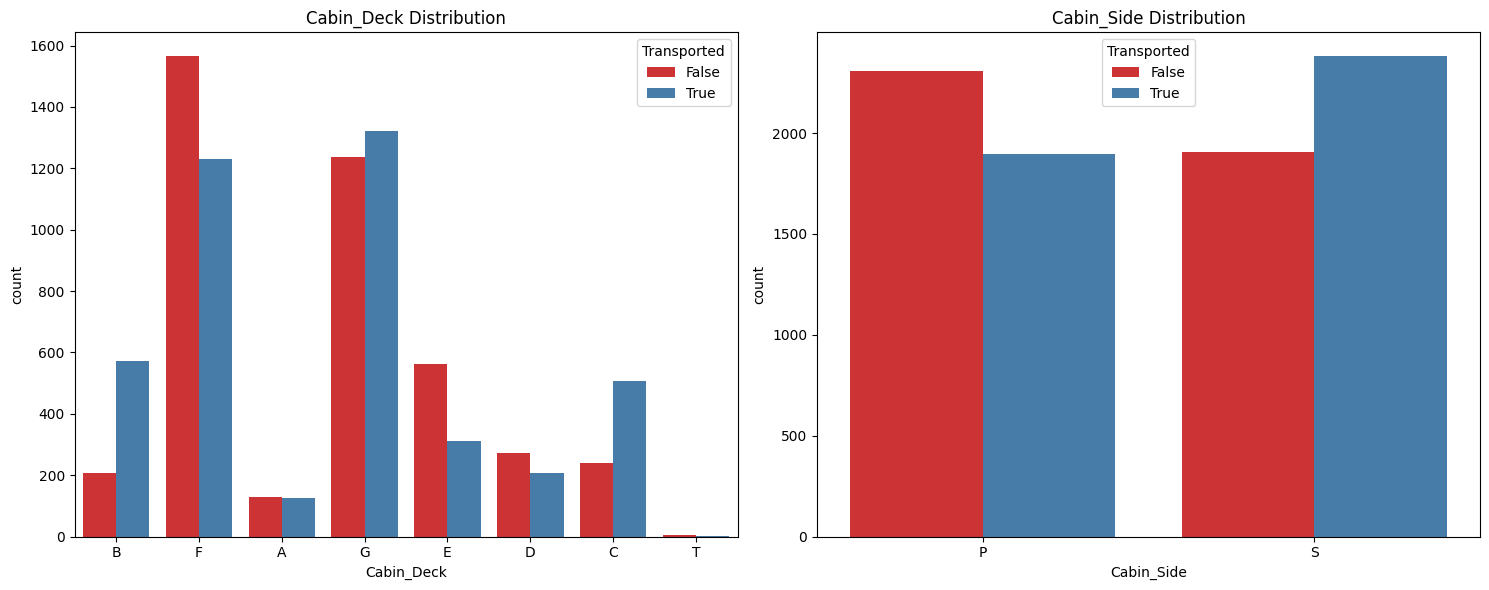

In [18]:
#Visualizing: Cabin_Deck, Cabin_Side
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.countplot(x="Cabin_Deck",hue="Transported", data=train_df, palette="Set1")
plt.title("Cabin_Deck Distribution")

plt.subplot(1,2,2)
sns.countplot(x="Cabin_Side", hue="Transported", data=train_df, palette="Set1")
plt.title("Cabin_Side Distribution")
plt.tight_layout()
plt.show()

In [19]:
#REVISIT 1 ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
# Fill missing values with the median before converting to integers
train_df["Cabin_Number"] = train_df["Cabin_Number"].fillna(train_df["Cabin_Number"].median()).astype(int)
test_df["Cabin_Number"] = test_df["Cabin_Number"].fillna(test_df["Cabin_Number"].median()).astype(int)
# NaN type casting error


# Convert Cabin_Number to integer type
train_df["Cabin_Number"]=train_df["Cabin_Number"].astype(int)
test_df["Cabin_Number"]=test_df["Cabin_Number"].astype(int)

In [20]:
# some analysis on Cabin_Number
print("Total Unique values present in Cabin_Number feature is:",train_df["Cabin_Number"].nunique())
print("The Mean of Cabin_Number Feature is: ",train_df["Cabin_Number"].mean())
print("The Median of Cabin_Number Feature is:",train_df["Cabin_Number"].median())
print("The Minimum value of Cabin_Number feature is:",train_df["Cabin_Number"].min())
print("The Maximum value of Cabin_number Feature is:",train_df["Cabin_Number"].max())

Total Unique values present in Cabin_Number feature is: 1817
The Mean of Cabin_Number Feature is:  596.3989416772115
The Median of Cabin_Number Feature is: 427.0
The Minimum value of Cabin_Number feature is: 0
The Maximum value of Cabin_number Feature is: 1894


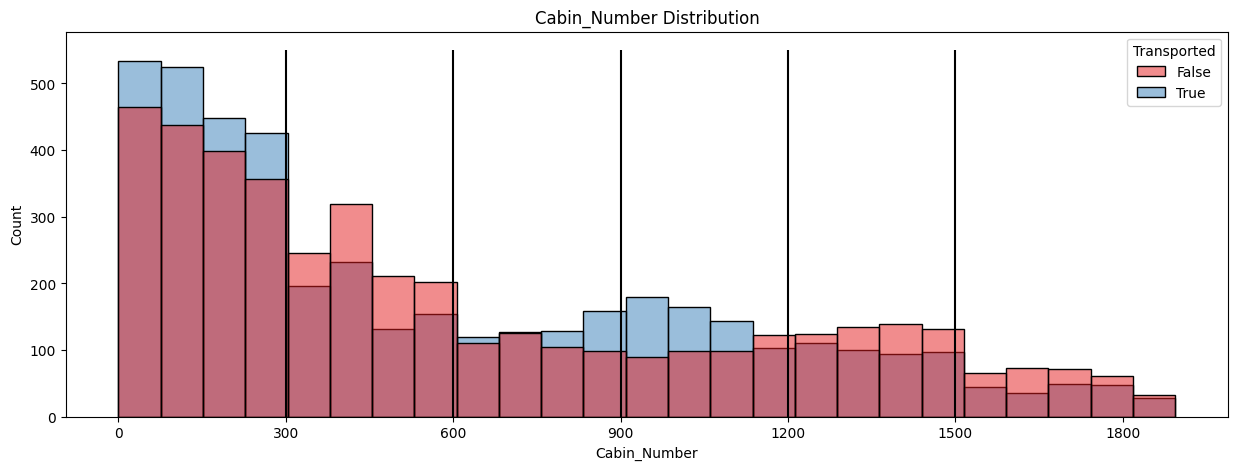

In [21]:
#Visualizing: Cabin_Number
plt.figure(figsize=(15,5))
sns.histplot(x="Cabin_Number",data=train_df,hue="Transported",palette="Set1")
plt.title("Cabin_Number Distribution")
plt.xticks(list(range(0,1900,300)))
plt.vlines(300,ymin=0,ymax=550,color="black")
plt.vlines(600,ymin=0,ymax=550,color="black")
plt.vlines(900,ymin=0,ymax=550,color="black")
plt.vlines(1200,ymin=0,ymax=550,color="black")
plt.vlines(1500,ymin=0,ymax=550,color="black")
plt.show()

In [22]:
#3 Cabin_Number-->Cabin_Regions
def cabin_regions(df):
    df["Cabin_Region1"] = (df["Cabin_Number"]<300)
    df["Cabin_Region2"] = (df["Cabin_Number"]>=300) & (df["Cabin_Number"]<600)
    df["Cabin_Region3"] = (df["Cabin_Number"]>=600) & (df["Cabin_Number"]<900)
    df["Cabin_Region4"] = (df["Cabin_Number"]>=900) & (df["Cabin_Number"]<1200)
    df["Cabin_Region5"] = (df["Cabin_Number"]>=1200) & (df["Cabin_Number"]<1500)
    df["Cabin_Region6"] = (df["Cabin_Number"]>=1500)

In [23]:
cabin_regions(train_df)
cabin_regions(test_df)

In [24]:
# Dropping Cabin_Number Feature
train_df.drop(columns=["Cabin_Number"],inplace=True)
test_df.drop(columns=["Cabin_Number"],inplace=True)

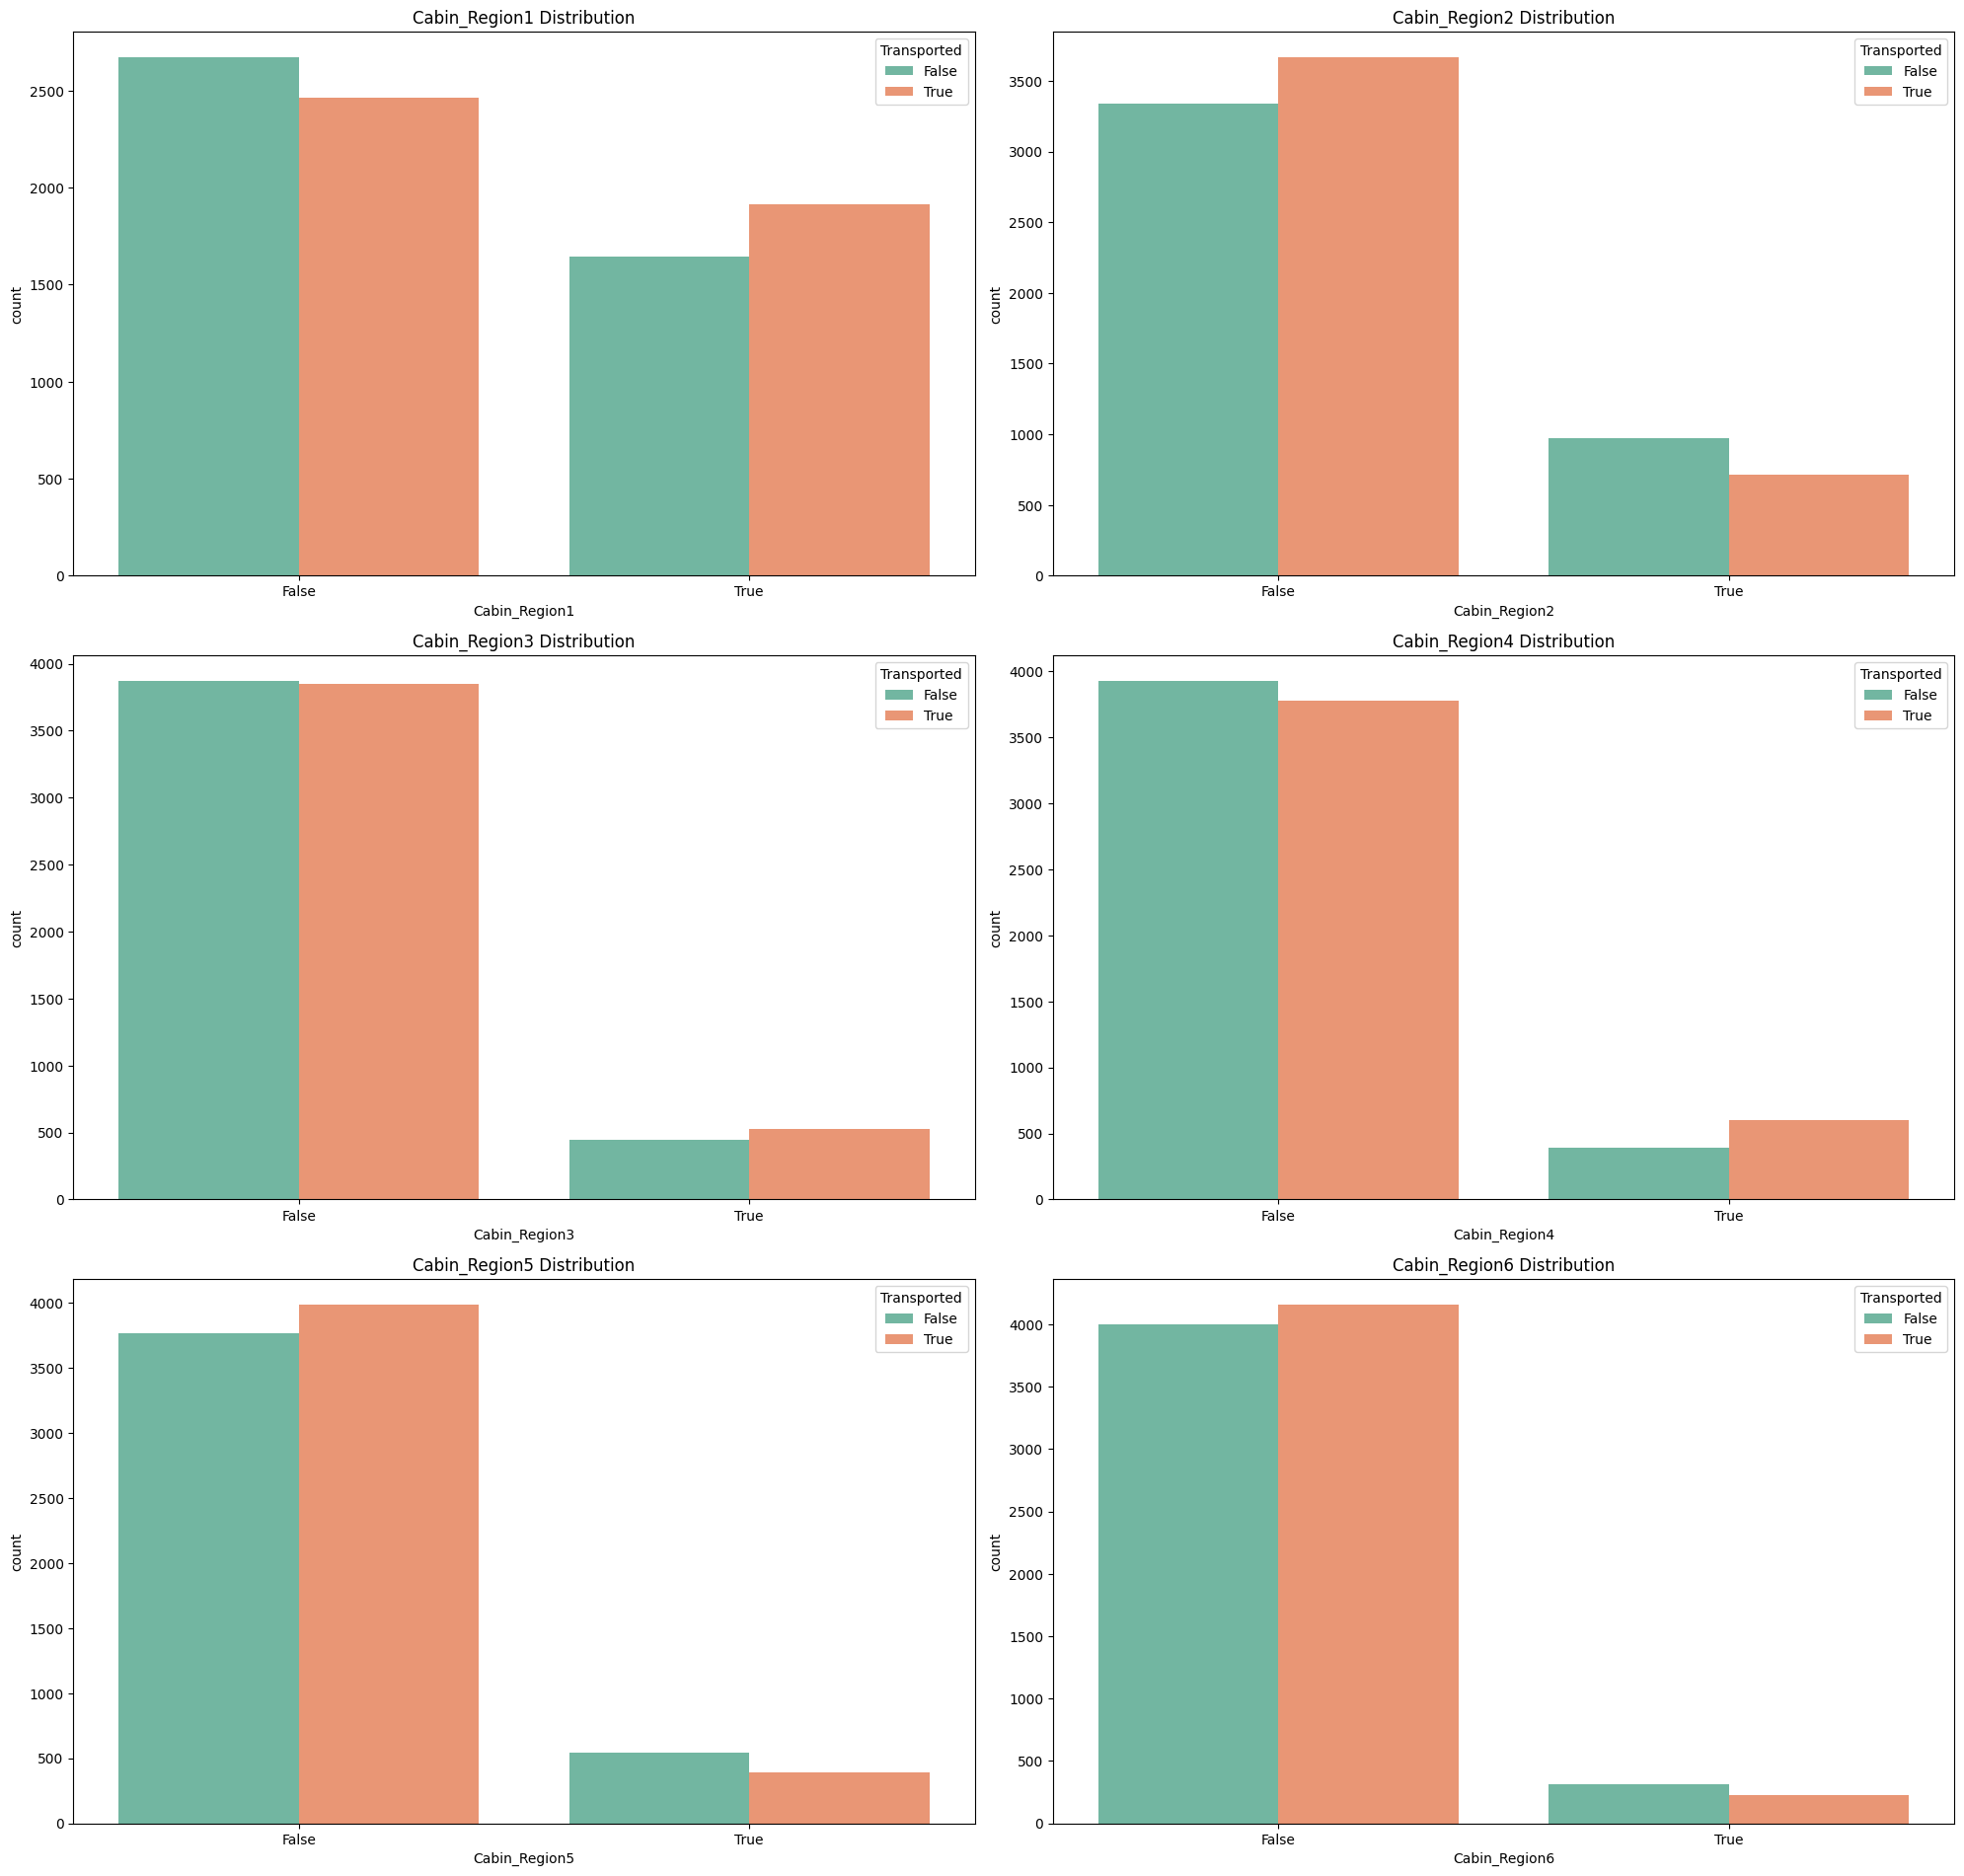

In [25]:
#Visualizing: Cabin_Regions
cols = ["Cabin_Region1","Cabin_Region2","Cabin_Region3","Cabin_Region4","Cabin_Region5","Cabin_Region6"]

plt.figure(figsize=(20,25))
for idx,value in enumerate(cols):
    plt.subplot(4,2,idx+1)
    sns.countplot(x=value, hue="Transported", data=train_df, palette="Set2")
    plt.title(f"{value} Distribution")
    plt.tight_layout()

In [26]:
#4 Age-->Age_Group
def age_group(df):
    age_group  = []
    for i in df["Age"]:
        if i<=12:
            age_group.append("Age_0-12")
        elif (i>12 and i<=18):
            age_group.append("Age_13-18")
        elif (i>18 and i<=25):
            age_group.append("Age_19-25")
        elif (i>25 and i<=32):
            age_group.append("Age_26-32")
        elif (i>32 and i<=50):
            age_group.append("Age_33_50")
        elif (i>50):
            age_group.append("age_50+")
        else:
            age_group.append(np.nan)
        
    df["Age Group"] = age_group

In [27]:
age_group(train_df)
age_group(test_df)

Text(0.5, 1.0, 'Age Group Distribution')

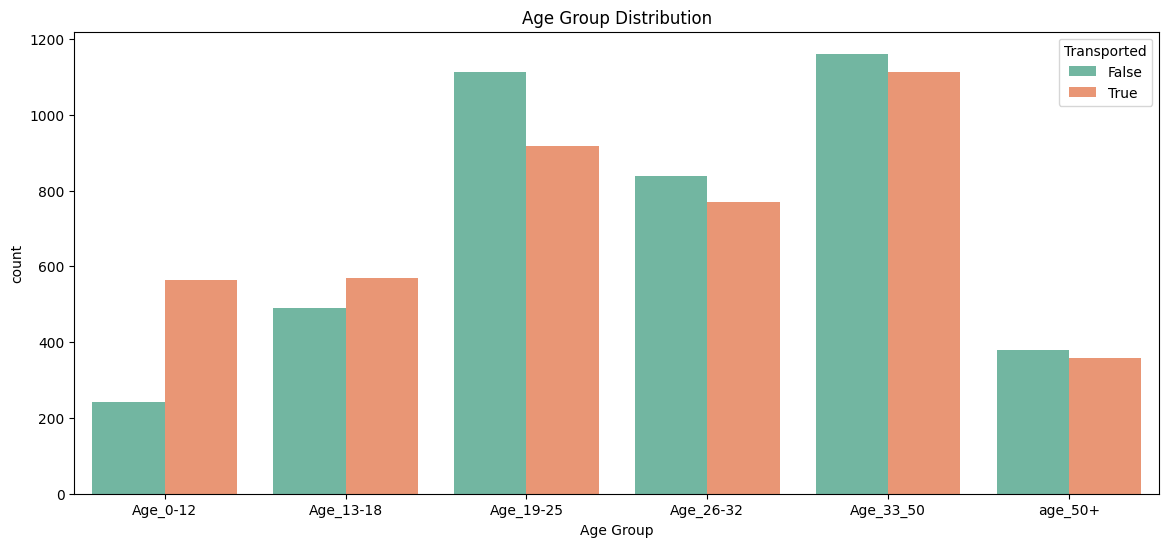

In [28]:
#Visualizing: Age_Group
order = sorted(train_df["Age Group"].value_counts().keys().to_list())

plt.figure(figsize=(14,6))
sns.countplot(x="Age Group",hue="Transported", data=train_df, palette="Set2",order=order)
plt.title("Age Group Distribution")

In [29]:
#5 RoomService, FoodCourt, ShoppingMall, Spa, VRDeck --> Total Expenditure
exp_cols = ["RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]

def new_exp_features(df):
    df["Total Expenditure"] = df[exp_cols].sum(axis=1)
    df["No Spending"] = (df["Total Expenditure"]==0)

In [30]:
new_exp_features(train_df)
new_exp_features(test_df)

Text(0.5, 1.0, 'Total Expenditure Distribution')

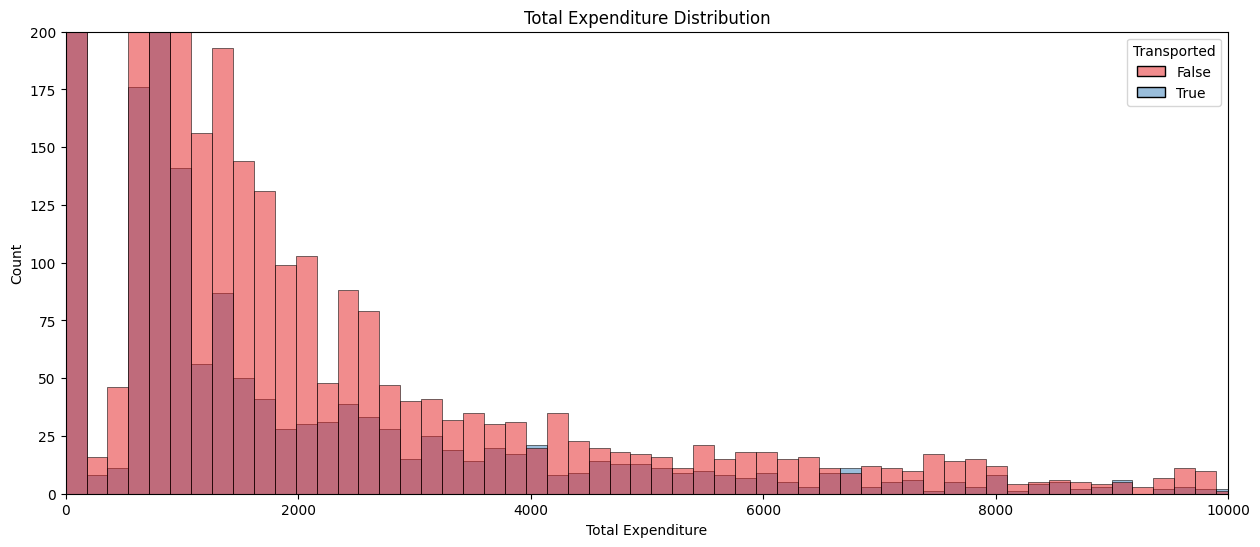

In [31]:
#Visualizing: Total Expenditure
plt.figure(figsize=(15,6))
sns.histplot(x="Total Expenditure", hue="Transported", data=train_df, palette="Set1",bins=200)
plt.ylim(0,200)
plt.xlim(0,10000)
plt.title("Total Expenditure Distribution")

In [32]:
# some analysis on Total Expenditure
mean = round(train_df["Total Expenditure"].mean())
median = train_df["Total Expenditure"].median()

print("Mean value of Total Expenditure feature is = ",mean)
print("Median value of Total Expenditure feature is = ",median)

Mean value of Total Expenditure feature is =  1441
Median value of Total Expenditure feature is =  716.0


In [33]:
#6 Total Expenditure --> Expenditure Category
def expenditure_category(df):
    expense_category = []
    
    for i in df["Total Expenditure"]:
        if i==0:
            expense_category.append("No Expense")
        elif (i>0 and i<=716):
            expense_category.append("Low Expense")
        elif (i>716 and i<=1441):
            expense_category.append("Medium Expense")
        elif (i>1441):
            expense_category.append("High Expense")
    
    df["Expenditure Category"] = expense_category

In [34]:
expenditure_category(train_df)
expenditure_category(test_df)

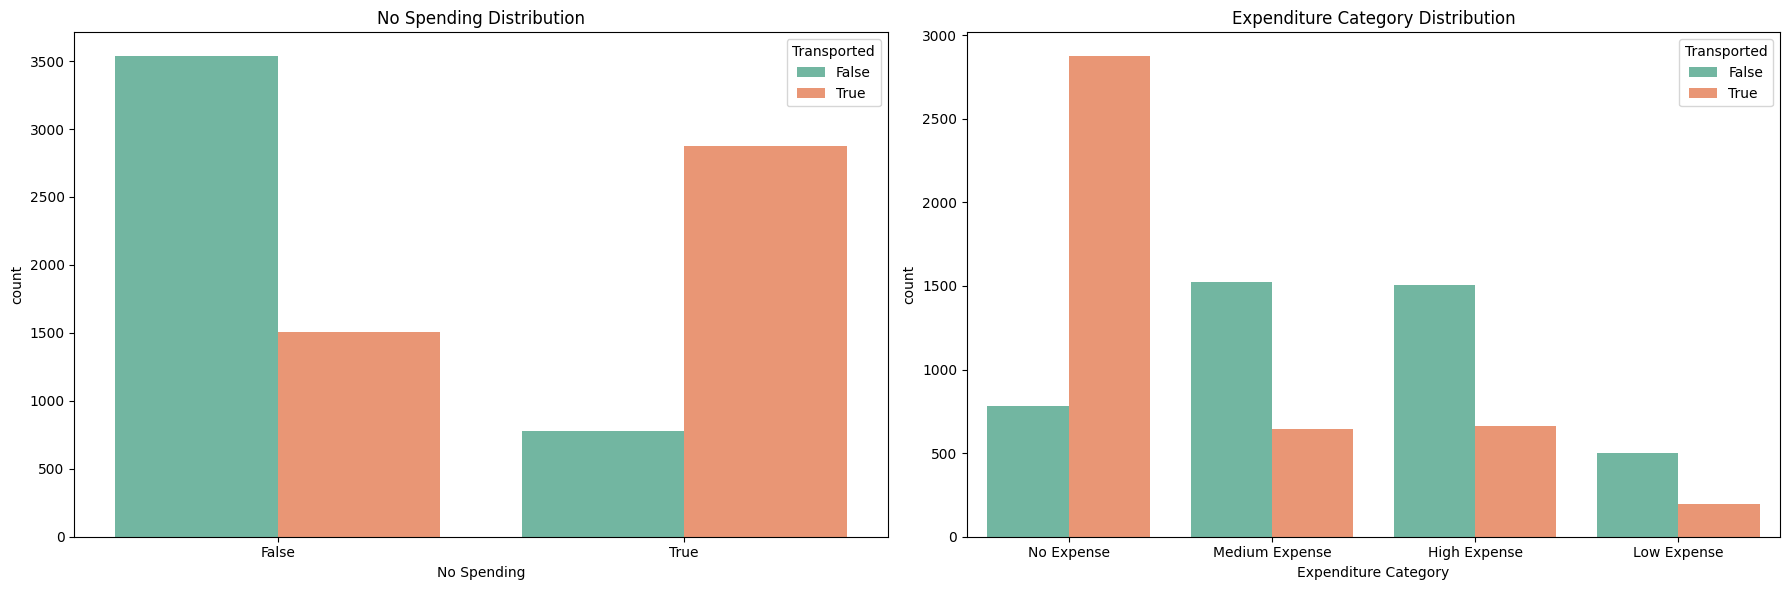

In [35]:
#Visualizing: No Spending, Expenditure Category
cols = ["No Spending", "Expenditure Category"]

plt.figure(figsize=(18,6))
for idx,column in enumerate(cols):
    plt.subplot(1,2,idx+1)
    sns.countplot(x=column, hue="Transported", data=train_df, palette="Set2")
    plt.title(f"{column} Distribution")
    plt.tight_layout()

In [36]:
#Missing values

In [37]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,8514.0,28.827930,14.489021,0.0,19.0,27.0,38.0,79.0
RoomService,8512.0,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,458.077203,1611.489240,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.138778,1136.705535,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,304.854791,1145.717189,0.0,0.0,0.0,46.0,24133.0
Group_Size,8693.0,2.035546,1.596347,1.0,1.0,1.0,3.0,8.0
Total Expenditure,8693.0,1440.866329,2803.045694,0.0,0.0,716.0,1441.0,35987.0


In [38]:
#pass_df = test_df[["PassengerId"]]

In [39]:
cols = ["PassengerId","Cabin","Name"]
train_df.drop(columns =cols, inplace=True)
test_df.drop(columns=cols, inplace=True)

In [40]:
cat_cols = train_df.select_dtypes(include=["object","bool"]).columns.tolist()
cat_cols.remove("Transported")
num_cols = train_df.select_dtypes(include=["int","float"]).columns.tolist()

In [41]:
print("Categorical Columns:",cat_cols)
print("\nNumerical Columns:",num_cols)

Categorical Columns: ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Travelling_Solo', 'Cabin_Deck', 'Cabin_Side', 'Cabin_Region1', 'Cabin_Region2', 'Cabin_Region3', 'Cabin_Region4', 'Cabin_Region5', 'Cabin_Region6', 'Age Group', 'No Spending', 'Expenditure Category']

Numerical Columns: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Group_Size', 'Total Expenditure']


In [42]:
def fill_missingno(df):
    imputer1 = SimpleImputer(strategy="most_frequent")     ##To fill Categorical Features.
    imputer2 = SimpleImputer(strategy="median")            ##To fill numeircal features.
    df[cat_cols] = imputer1.fit_transform(df[cat_cols])
    df[num_cols] = imputer2.fit_transform(df[num_cols])

In [43]:
fill_missingno(train_df)
fill_missingno(test_df)

In [44]:
# Display the number of missing values for each column
missing_values = train_df.isnull().sum()
print("Number of missing values in each column:")
print(missing_values)

# To include percentages:
missing_percentage = (train_df.isnull().sum() / len(train_df)) * 100
print("\nPercentage of missing values in each column:")
print(missing_percentage)

Number of missing values in each column:
HomePlanet              0
CryoSleep               0
Destination             0
Age                     0
VIP                     0
RoomService             0
FoodCourt               0
ShoppingMall            0
Spa                     0
VRDeck                  0
Transported             0
Travelling_Solo         0
Group_Size              0
Cabin_Deck              0
Cabin_Side              0
Cabin_Region1           0
Cabin_Region2           0
Cabin_Region3           0
Cabin_Region4           0
Cabin_Region5           0
Cabin_Region6           0
Age Group               0
Total Expenditure       0
No Spending             0
Expenditure Category    0
dtype: int64

Percentage of missing values in each column:
HomePlanet              0.0
CryoSleep               0.0
Destination             0.0
Age                     0.0
VIP                     0.0
RoomService             0.0
FoodCourt               0.0
ShoppingMall            0.0
Spa                     0.

In [45]:
#Checking for duplicate values
print("Duplicate values in training data is: ",train_df.duplicated())
print("Duplicate values in training data is: ",train_df.duplicated().sum())
print("Duplicate values in testing data is: ",test_df.duplicated().sum())

Duplicate values in training data is:  0       False
1       False
2       False
3       False
4       False
        ...  
8688    False
8689    False
8690    False
8691    False
8692    False
Length: 8693, dtype: bool
Duplicate values in training data is:  459
Duplicate values in testing data is:  179


In [46]:
train_df.dtypes

HomePlanet               object
CryoSleep                object
Destination              object
Age                     float64
VIP                      object
RoomService             float64
FoodCourt               float64
ShoppingMall            float64
Spa                     float64
VRDeck                  float64
Transported                bool
Travelling_Solo          object
Group_Size              float64
Cabin_Deck               object
Cabin_Side               object
Cabin_Region1            object
Cabin_Region2            object
Cabin_Region3            object
Cabin_Region4            object
Cabin_Region5            object
Cabin_Region6            object
Age Group                object
Total Expenditure       float64
No Spending              object
Expenditure Category     object
dtype: object

In [47]:
cols = ["CryoSleep","VIP","Travelling_Solo","No Spending","Cabin_Region1","Cabin_Region2","Cabin_Region3","Cabin_Region4",
       "Cabin_Region5","Cabin_Region6"]

train_df[cols] = train_df[cols].astype(bool)
test_df[cols] = test_df[cols].astype(bool)

In [48]:
nominal_cat_cols = ["HomePlanet","Destination"]
ordinal_cat_cols = ["CryoSleep","VIP","Travelling_Solo","Cabin_Deck","Cabin_Side","Cabin_Region1","Cabin_Region2",
                    "Cabin_Region3","Cabin_Region4","Cabin_Region5","Cabin_Region6","Age Group","No Spending",
                    "Expenditure Category"]

In [49]:
#Feature Encoding

In [50]:
enc = LabelEncoder()

In [51]:
train_df[ordinal_cat_cols] = train_df[ordinal_cat_cols].apply(enc.fit_transform)
test_df[ordinal_cat_cols] = test_df[ordinal_cat_cols].apply(enc.fit_transform)

In [52]:
train_df = pd.get_dummies(train_df,columns=nominal_cat_cols)
test_df = pd.get_dummies(test_df,columns=nominal_cat_cols)

In [53]:
train_df["Transported"] = train_df["Transported"].replace({False: 0, True: 1}).astype(int)


C:\Users\wilbe_7vdqyk8\AppData\Local\Temp\ipykernel_4000\369982673.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df["Transported"] = train_df["Transported"].replace({False: 0, True: 1}).astype(int)


In [54]:
train_df.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Travelling_Solo,...,Age Group,Total Expenditure,No Spending,Expenditure Category,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,1,...,4,0.0,1,3,False,True,False,False,False,True
1,0,24.0,0,109.0,9.0,25.0,549.0,44.0,1,1,...,2,736.0,0,2,True,False,False,False,False,True
2,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,0,...,5,10383.0,0,0,False,True,False,False,False,True
3,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,0,...,4,5176.0,0,0,False,True,False,False,False,True
4,0,16.0,0,303.0,70.0,151.0,565.0,2.0,1,1,...,1,1091.0,0,2,True,False,False,False,False,True


In [55]:
test_df.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Travelling_Solo,Group_Size,...,Age Group,Total Expenditure,No Spending,Expenditure Category,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,1,27.0,0,0.0,0.0,0.0,0.0,0.0,1,1.0,...,3,0.0,1,3,True,False,False,False,False,True
1,0,19.0,0,0.0,9.0,0.0,2823.0,0.0,1,1.0,...,2,2832.0,0,0,True,False,False,False,False,True
2,1,31.0,0,0.0,0.0,0.0,0.0,0.0,1,1.0,...,3,0.0,1,3,False,True,False,True,False,False
3,0,38.0,0,0.0,6652.0,0.0,181.0,585.0,1,1.0,...,4,7418.0,0,0,False,True,False,False,False,True
4,0,20.0,0,10.0,0.0,635.0,0.0,0.0,1,1.0,...,2,645.0,0,1,True,False,False,False,False,True


In [56]:
#

In [57]:
X = train_df.drop(columns=["Transported"])
y = train_df[["Transported"]]

In [58]:
#Feature scaling

In [59]:
scaler = StandardScaler()

In [60]:
X_scaled = scaler.fit_transform(X)
test_df_scaled = scaler.fit_transform(test_df)

In [61]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [62]:
print(x_train.shape, y_train.shape)
print(x_test.shape,y_test.shape)

(6954, 28) (6954, 1)
(1739, 28) (1739, 1)


In [63]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(X_scaled,y,test_size=0.2,random_state=0)

In [64]:
training_score = []
testing_score = []
def model_prediction(model):
    model.fit(x_train1,y_train1)
    x_train_pred1 = model.predict(x_train1)
    x_test_pred1 = model.predict(x_test1)
    a = accuracy_score(y_train1,x_train_pred1)*100
    b = accuracy_score(y_test1,x_test_pred1)*100
    training_score.append(a)
    testing_score.append(b)
    
    print(f"Accuracy_Score of {model} model on Training Data is:",a)
    print(f"Accuracy_Score of {model} model on Testing Data is:",b)

In [65]:
model_prediction(LogisticRegression())

Accuracy_Score of LogisticRegression() model on Training Data is: 79.93960310612597
Accuracy_Score of LogisticRegression() model on Testing Data is: 79.01092581943647


c:\Users\wilbe_7vdqyk8\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [66]:
model_prediction(KNeighborsClassifier())

c:\Users\wilbe_7vdqyk8\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy_Score of KNeighborsClassifier() model on Training Data is: 83.98044291055507
Accuracy_Score of KNeighborsClassifier() model on Testing Data is: 75.67567567567568


In [67]:
def model_prediction(model):
    model.fit(x_train,y_train)
    x_train_pred = model.predict(x_train)
    x_test_pred = model.predict(x_test)
    a = accuracy_score(y_train,x_train_pred)*100
    b = accuracy_score(y_test,x_test_pred)*100
    training_score.append(a)
    testing_score.append(b)
    
    print(f"Accuracy_Score of {model} model on Training Data is:",a)
    print(f"Accuracy_Score of {model} model on Testing Data is:",b)

In [68]:
model_prediction(DecisionTreeClassifier())

Accuracy_Score of DecisionTreeClassifier() model on Training Data is: 98.53321829163072
Accuracy_Score of DecisionTreeClassifier() model on Testing Data is: 74.06555491661875


In [69]:
model_prediction(RandomForestClassifier())

c:\Users\wilbe_7vdqyk8\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy_Score of RandomForestClassifier() model on Training Data is: 98.53321829163072
Accuracy_Score of RandomForestClassifier() model on Testing Data is: 79.87349051178838


In [70]:
model_prediction(XGBClassifier())

Accuracy_Score of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) model on Training Data is: 92.52228932988208
Accuracy_Score of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, de

In [71]:
models = ["Logistic Regression","KNN","Decision Tree","Random Forest","XGBoost"]

In [72]:
df = pd.DataFrame({"Algorithms":models,
                   "Training Score":training_score,
                   "Testing Score":testing_score})
df

,Algorithms,Training Score,Testing Score
0,Logistic Regression,79.939603,79.010926
1,KNN,83.980443,75.675676
2,Decision Tree,98.533218,74.065555
3,Random Forest,98.533218,79.873491
4,XGBoost,92.522289,80.966072


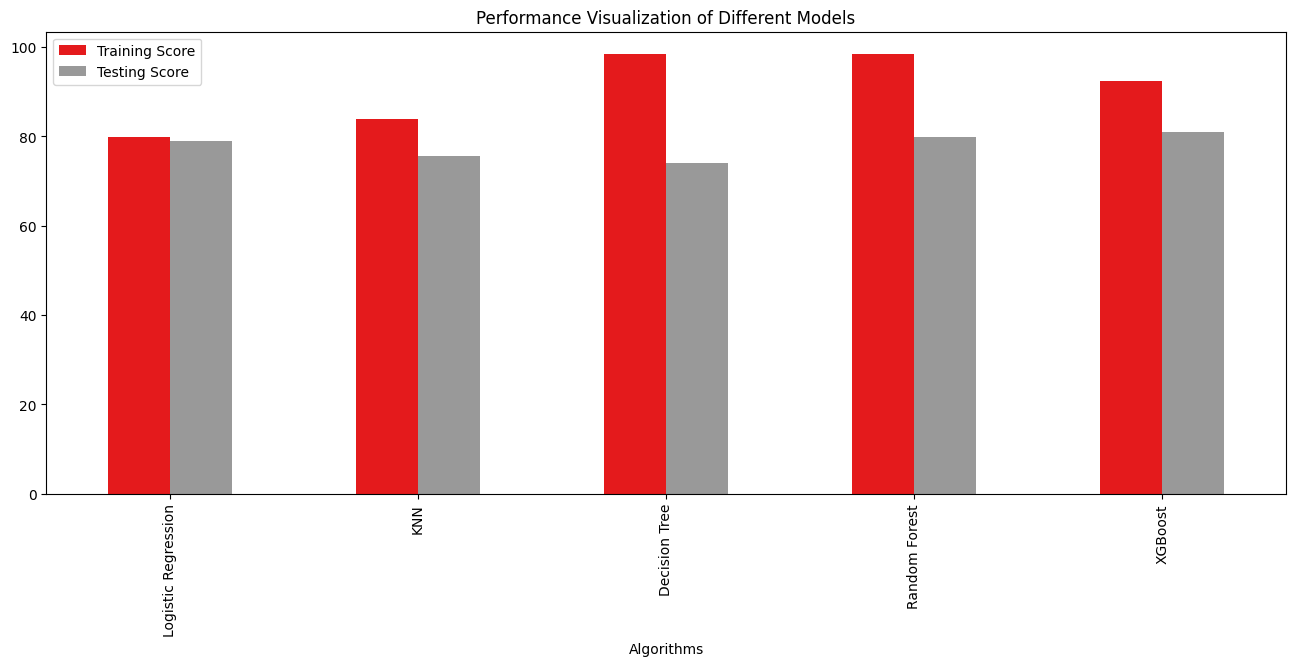

In [73]:
df.plot(x="Algorithms",y=["Training Score","Testing Score"], figsize=(16,6),kind="bar",
        title="Performance Visualization of Different Models",colormap="Set1")
plt.show()